# Decision Tree

## Import Libraries

In [575]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# classification model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#feature importance
from sklearn.inspection import permutation_importance

# metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

## Functions

Here we have some functions created to facilitate the modeling phase:

In [576]:
def xy_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    return X_train, X_test, y_train, y_test

### Model Performance

In [577]:
def metrics_class(actual, predicted):
    kappa = cohen_kappa_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    f1 = f1_score(actual, predicted)
    auc_score = roc_auc_score(actual, predicted)
    
    index = ['Cohen Kappa Score', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC Score']
    metrics = pd.Series([kappa, accuracy, precision, recall, f1, auc_score], index=index)
    return metrics.round(2)

In [578]:
def plot_cm(actual, prediction):
    cm = confusion_matrix(actual, prediction)
    # Visualize confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Set2_r', fmt='g', ax=ax)

    # Set axis labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()



### Feature Importance

In [579]:
def importance(model, X):
    importances = pd.DataFrame(data=model.feature_importances_,
                        index= X.columns)
    importances_sorted = importances.iloc[:,0].sort_values(ascending=False).round(3)
    return importances_sorted

In [580]:
def plot_importance(list):
    plt.figure(figsize=(18,8))
    plt.suptitle('Feature Importance Scores', y=0.95)
    plot = sns.barplot(x = list, y = list.index)
    return plot

In [581]:
def perm_importance(model, X, y):
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    train_result = permutation_importance(
        model, X_train, y_train, n_repeats=10, random_state=1, n_jobs=2
    )
    test_results = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
    )
    sorted_importances_idx = train_result.importances_mean.argsort()[::-1]
    train_importances = pd.DataFrame(
        train_result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    test_importances = pd.DataFrame(
        test_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    return train_importances, test_importances

In [582]:
def plot_perm_impt(train_impt, test_impt):
    fig = plt.figure(figsize = (14,7))
    plt.suptitle("Permutation Importances", fontsize = 14, y=1)

    #  subplot #1
    plt.subplot(121)
    plt.title('Train Set')
    plt.xlabel("Decrease in accuracy score")
    ax = sns.boxplot(train_impt, orient='h', whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    
    #  subplot #2
    plt.subplot(122)
    plt.title('Test Set')
    plt.xlabel("Decrease in accuracy score")
    ax = sns.boxplot(test_impt, orient='h', whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    
    plt.tight_layout()
    plt.show()

## Models

In [583]:
dt = DecisionTreeClassifier(criterion='gini', random_state=1)
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=1)

> **Note:** We will be using both gini index and entropy-based models to compare the difference between them in terms of model performance and results.

## Load Datasets

### Original Dataset

In [584]:
X = df = pd.read_csv(r'./../data/X.csv')
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [585]:
X.shape

(17976, 20)

In [586]:
y = df = pd.read_csv(r'./../data/y.csv')
y.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No


In [587]:
y_int = pd.Series(y.offer_accepted)
y_int.unique()

array(['No', 'Yes'], dtype=object)

In [588]:
y_int = y_int.apply(lambda x: 0 if x == 'No' else 1)
y_int

0        0
1        0
2        0
3        0
4        0
        ..
17971    0
17972    0
17973    0
17974    0
17975    0
Name: offer_accepted, Length: 17976, dtype: int64

In [589]:
y_int.value_counts()

offer_accepted
0    16955
1     1021
Name: count, dtype: int64

In [590]:
# Apply Transformation on X
independents = X.copy() # make a separate df to preserve the column headers

transformer = StandardScaler().fit(independents)
standard_x = transformer.transform(independents)
X = pd.DataFrame(standard_x)
X.columns = independents.columns # put the column headers back
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.223349,-0.267589,0.095704,0.343147,1.410295,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-1.405430,-1.953241,-1.741902,-0.794628,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,-0.876449,-1.415407,-1.620841,-1.016458,1.410295,-0.007894,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,1.076589,1.662932,0.139070,-0.699813,-0.005039,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,1.982953,0.781845,-0.108474,-0.796417,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147


#### X Variation: Remove 4 columns of Quarter Balances

In [591]:
X_avgbal = X.drop(columns=(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']))
X_avgbal

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.410295,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,1.410295,-0.007894,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,-0.005039,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,-0.541352,-1.133443,-0.476212,1.346760,-2.206799,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
17972,-0.541352,1.375766,-0.476212,-0.447855,-0.256976,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
17973,-0.541352,0.121161,-0.476212,0.449452,0.418896,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
17974,-0.541352,2.630370,1.863330,-1.345162,0.233335,-0.005039,-0.007894,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147


### SMOTE Data

In [592]:
smote_data = pd.read_csv(r'./../data/oversampled_data.csv')

In [593]:
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33910 entries, 0 to 33909
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bank_accounts_open        33910 non-null  float64
 1   credit_cards_held         33910 non-null  float64
 2   homes_owned               33910 non-null  float64
 3   household_size            33910 non-null  float64
 4   average_balance           33910 non-null  float64
 5   q1_balance                33910 non-null  float64
 6   q2_balance                33910 non-null  float64
 7   q3_balance                33910 non-null  float64
 8   q4_balance                33910 non-null  float64
 9   income_level              33910 non-null  float64
 10  credit_rating             33910 non-null  float64
 11  reward_Air Miles          33910 non-null  float64
 12  reward_Cash Back          33910 non-null  float64
 13  reward_Points             33910 non-null  float64
 14  mailer

In [594]:
X_sm = smote_data.drop('offer_accepted', axis=1)
X_sm

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.223349,-0.267589,0.095704,0.343147,1.410295,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-1.405430,-1.953241,-1.741902,-0.794628,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,-0.876449,-1.415407,-1.620841,-1.016458,1.410295,-0.007894,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,1.076589,1.662932,0.139070,-0.699813,-0.005039,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,1.982953,0.781845,-0.108474,-0.796417,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33905,1.575537,0.365992,1.406778,1.171654,-2.006040,-1.383443,-1.399945,-1.216592,-1.143719,-1.144176,0.230839,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,1.354744,-1.354744
33906,-0.541352,0.121161,-0.476212,-1.339703,0.509354,-0.090918,1.061438,0.733175,-0.216821,-1.420373,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
33907,-0.541352,-0.742960,-0.476212,-1.345162,0.100980,1.500388,0.608086,-0.670130,-1.245289,-0.445548,-0.850492,-0.711980,1.413683,-0.701980,-0.983886,0.983886,-2.391127,2.391127,0.703352,-0.703352
33908,-0.541352,0.121161,-0.476212,0.207690,0.117587,0.101837,0.098037,-0.168242,0.268133,0.376295,-0.337504,-0.711980,-0.707372,1.424543,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744


In [595]:
y_sm = smote_data.iloc[:, -1]
y_sm = y_sm.map({'No': 0, 'Yes': 1})
y_sm

0        0
1        0
2        0
3        0
4        0
        ..
33905    1
33906    1
33907    1
33908    1
33909    1
Name: offer_accepted, Length: 33910, dtype: int64

#### X Variation: Remove 4 columns of Quarter Balances

In [596]:
# Remove the quarterly balances to eliminate multicollinearity
Xsm_avgbal = X_sm.drop(columns=(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']))
Xsm_avgbal

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.410295,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,1.410295,-0.007894,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,-0.005039,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33905,1.575537,0.365992,1.406778,1.171654,-2.006040,-1.144176,0.230839,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,1.354744,-1.354744
33906,-0.541352,0.121161,-0.476212,-1.339703,0.509354,-1.420373,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
33907,-0.541352,-0.742960,-0.476212,-1.345162,0.100980,-0.445548,-0.850492,-0.711980,1.413683,-0.701980,-0.983886,0.983886,-2.391127,2.391127,0.703352,-0.703352
33908,-0.541352,0.121161,-0.476212,0.207690,0.117587,0.376295,-0.337504,-0.711980,-0.707372,1.424543,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744


### Add random variable in X
- This variable will be useful when checking for feature importance. Every variable below it could most likely be dropped.

In [597]:
X['random'] = np.random.random(size=len(X))
X_avgbal['random'] = np.random.random(size=len(X_avgbal))
X_sm['random'] = np.random.random(size=len(X_sm))
Xsm_avgbal['random'] = np.random.random(size=len(Xsm_avgbal))

## Modeling

### Original Data

In [598]:
X_train, X_test, y_train, y_test = xy_split(X, y_int)

In [599]:
#Checking the number of records
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(12583, 21) 12583
(5393, 21) 5393


In [600]:
# Fitting the model with gini criterion
dt.fit(X_train, y_train)

# Model predictions
dt_pred = dt.predict(X_test)

In [601]:
dt_metrics = metrics_class(y_test, dt_pred)
dt_metrics

Cohen Kappa Score    0.04
Accuracy             0.89
Precision            0.09
Recall               0.10
F1                   0.10
AUC Score            0.52
dtype: float64

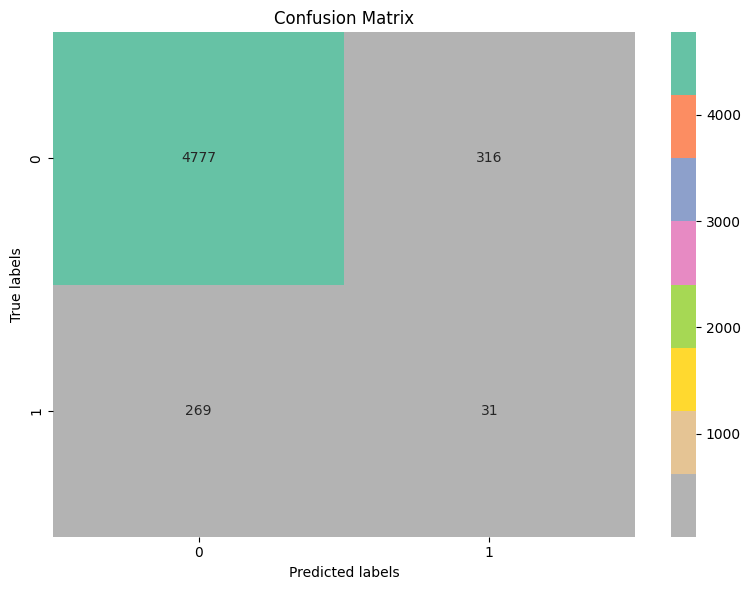

In [602]:
plot_cm(y_test, dt_pred)

In [603]:
# Fitting the model with entropy criterion
dt_entropy.fit(X_train, y_train)

# Model predictions
dt_ent_pred = dt.predict(X_test)

In [604]:
dt_ent_metrics = metrics_class(y_test, dt_ent_pred)
dt_ent_metrics

Cohen Kappa Score    0.04
Accuracy             0.89
Precision            0.09
Recall               0.10
F1                   0.10
AUC Score            0.52
dtype: float64

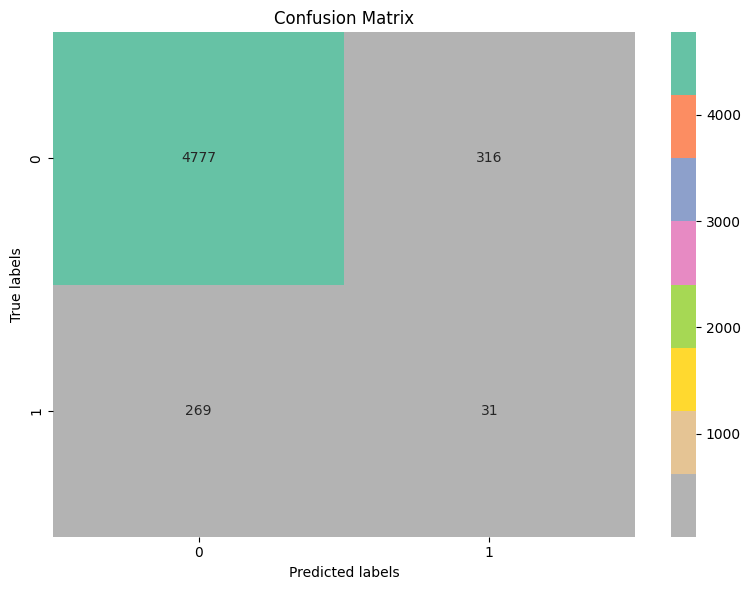

In [605]:
plot_cm(y_test, dt_ent_pred)

> **Note:** Model has high accuracy but as shown by the confusion matrix and the other metrics above, we can see how bad it is at predicting the 'Yes'. This could be highly due to the imbalanced nature of the training set.
>
> Both gini and entropy models have same results. We will be moving on with the gini criterion for the following models.

#### Feature Importance

In [606]:
importance_dt = importance(dt, X)
importance_dt

random                      0.163
q2_balance                  0.154
q1_balance                  0.138
q3_balance                  0.115
average_balance             0.108
q4_balance                  0.103
household_size              0.047
credit_rating               0.024
income_level                0.021
homes_owned                 0.019
credit_cards_held           0.018
bank_accounts_open          0.017
mailer_type_Postcard        0.016
own_your_home_No            0.012
overdraft_protection_Yes    0.009
reward_Cash Back            0.008
own_your_home_Yes           0.007
reward_Points               0.006
overdraft_protection_No     0.006
reward_Air Miles            0.005
mailer_type_Letter          0.004
Name: 0, dtype: float64

<Axes: xlabel='0'>

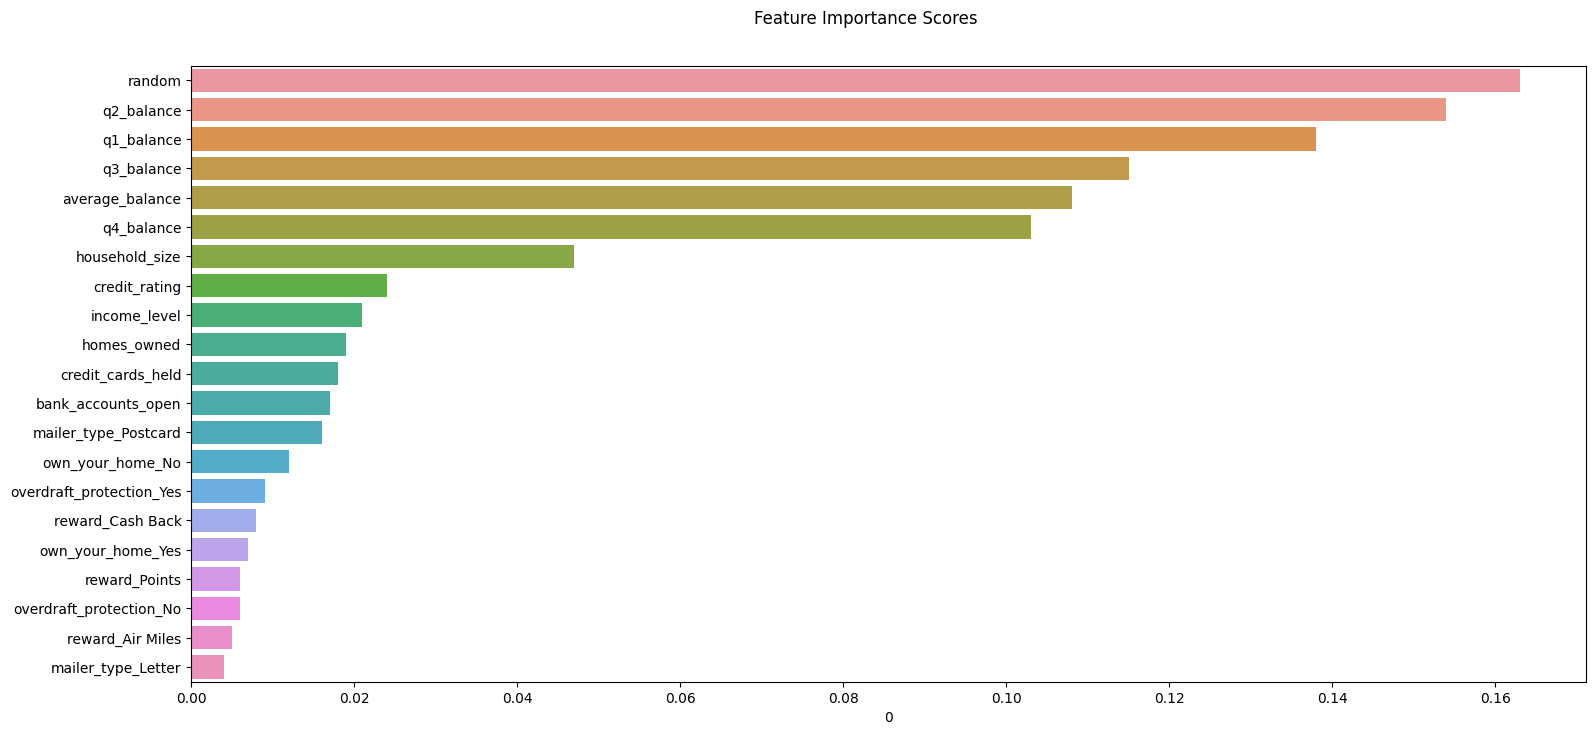

In [607]:
plot_importance(importance_dt)

> **Note:** We can clearly see the bias towards high cardinality features (continuous variables). Random variable added is also considered more important compared to other real variables provided.

#### Permutation Importance

In [608]:
train_impt, test_impt = perm_importance(dt, X, y_int)

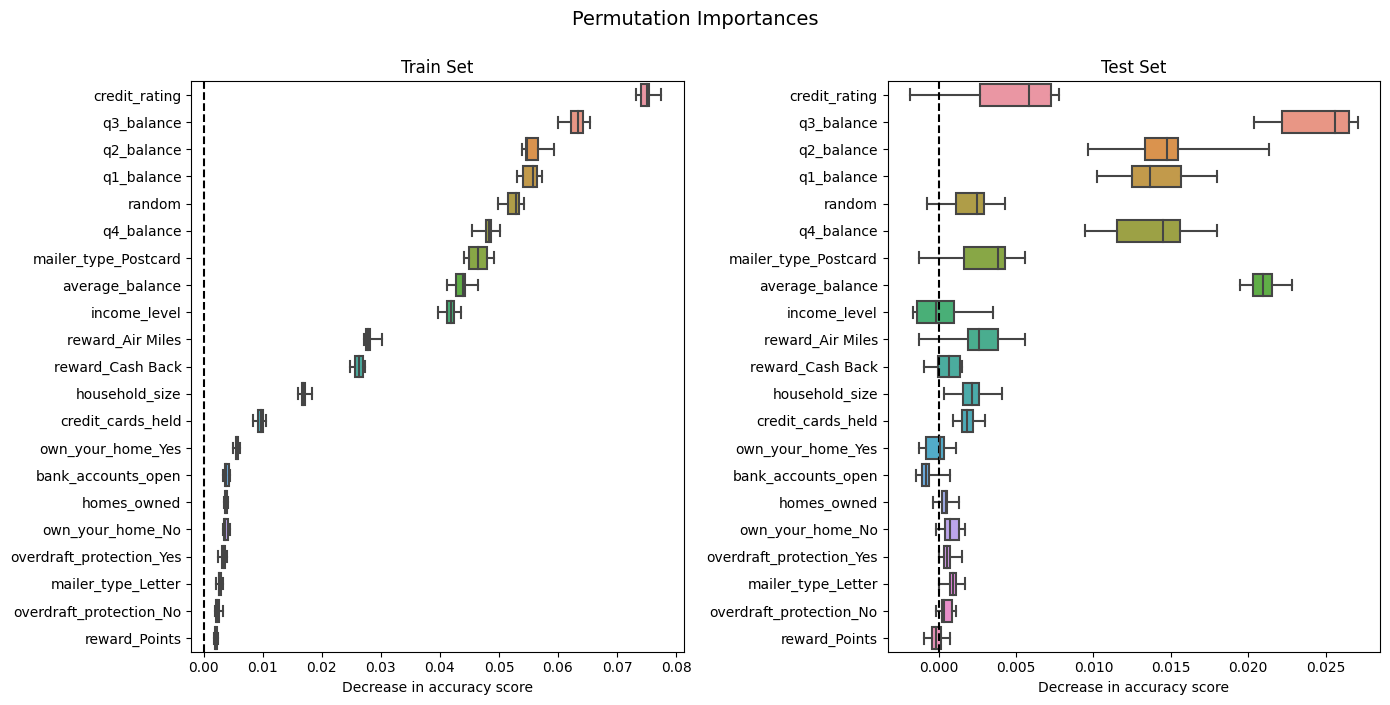

In [609]:
plot_perm_impt(train_impt, test_impt)

> **Top Variables (above random):**
> 1. credit_rating
> 2. q3 balance
> 3. q4 balance
> 4. q2_balance
> 5. q1_balance
> 6. average_balance
> 7. income_level
> 8. mailer_type_Postcard
>
> Here are the top variables according the permutation importance. Although we still have high cardinality features included in the most important variables, we also have new ones added to the list (credit_rating, income_level, mailer_type_Postcard).

### Original with X Variation: Remove 4 columns of Quarter Balances

In [610]:
Xavg_train, Xavg_test, yavg_train, yavg_test = xy_split(X_avgbal, y_int)

In [611]:
#Checking the number of records
print(Xavg_train.shape, len(yavg_train))
print(Xavg_test.shape, len(yavg_test))

(12583, 17) 12583
(5393, 17) 5393


In [612]:
# Fitting the model
dt.fit(Xavg_train, yavg_train)

# Model predictions
dtavg_pred = dt.predict(Xavg_test)

In [613]:
dtavg_metrics = metrics_class(yavg_test, dtavg_pred)
dtavg_metrics

Cohen Kappa Score    0.06
Accuracy             0.89
Precision            0.11
Recall               0.12
F1                   0.11
AUC Score            0.53
dtype: float64

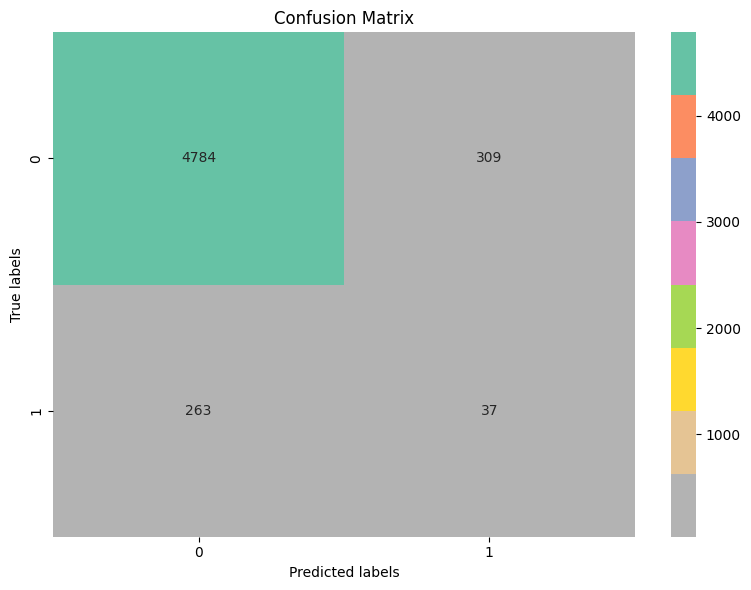

In [614]:
plot_cm(yavg_test, dtavg_pred)

> **Note:** Model performance is not that different from the original data which includes quaterly balances.

#### Feature Importance

In [615]:
importance_dtavg = importance(dt, X_avgbal)
importance_dtavg

random                      0.356
average_balance             0.337
household_size              0.062
credit_cards_held           0.048
homes_owned                 0.030
income_level                0.028
credit_rating               0.025
bank_accounts_open          0.019
own_your_home_Yes           0.016
own_your_home_No            0.014
mailer_type_Letter          0.014
overdraft_protection_Yes    0.012
reward_Points               0.012
reward_Air Miles            0.012
overdraft_protection_No     0.009
reward_Cash Back            0.004
mailer_type_Postcard        0.003
Name: 0, dtype: float64

<Axes: xlabel='0'>

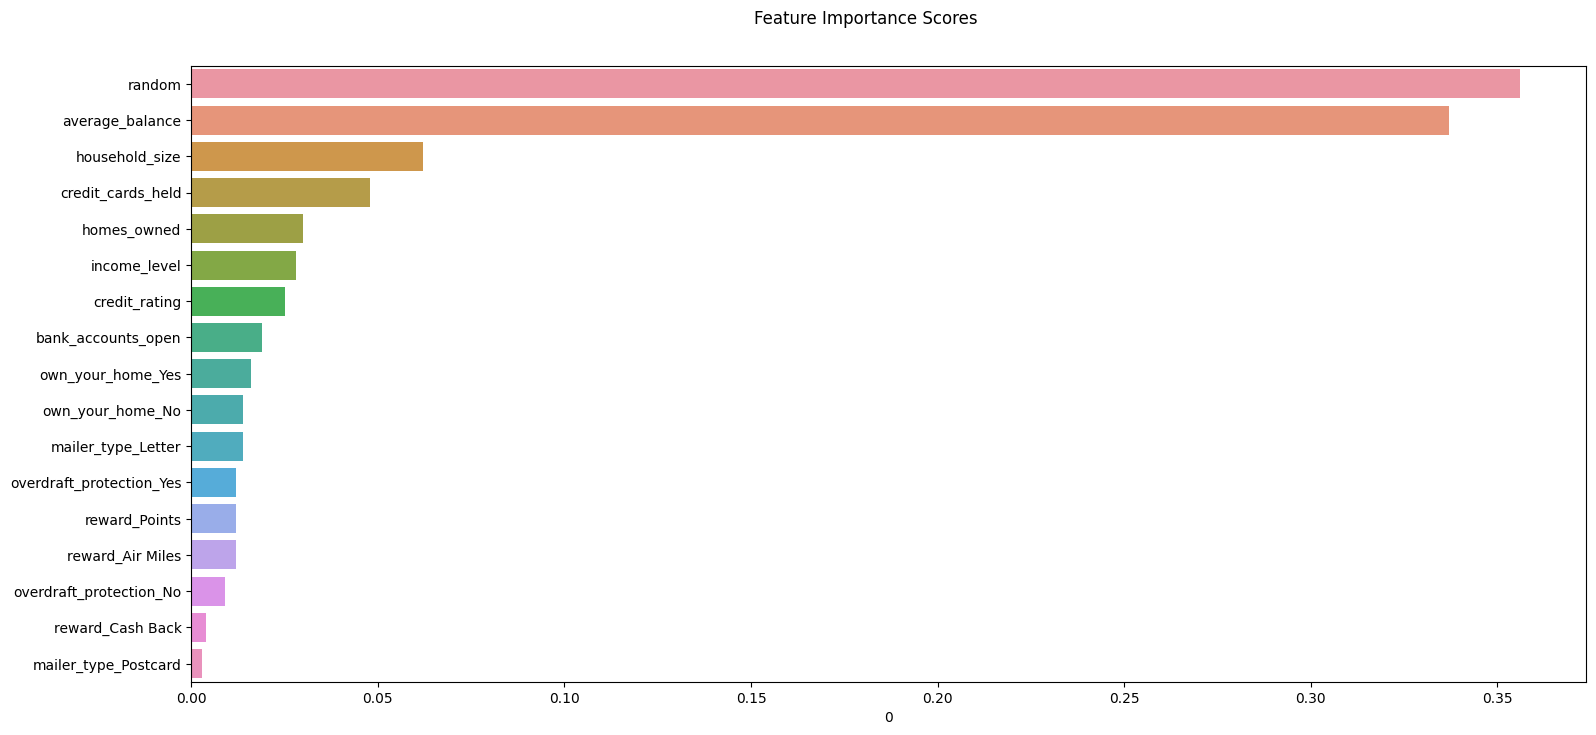

In [616]:
plot_importance(importance_dtavg)

#### Permutation Importance

In [617]:
train_impt, test_impt = perm_importance(dt, X_avgbal, y_int)

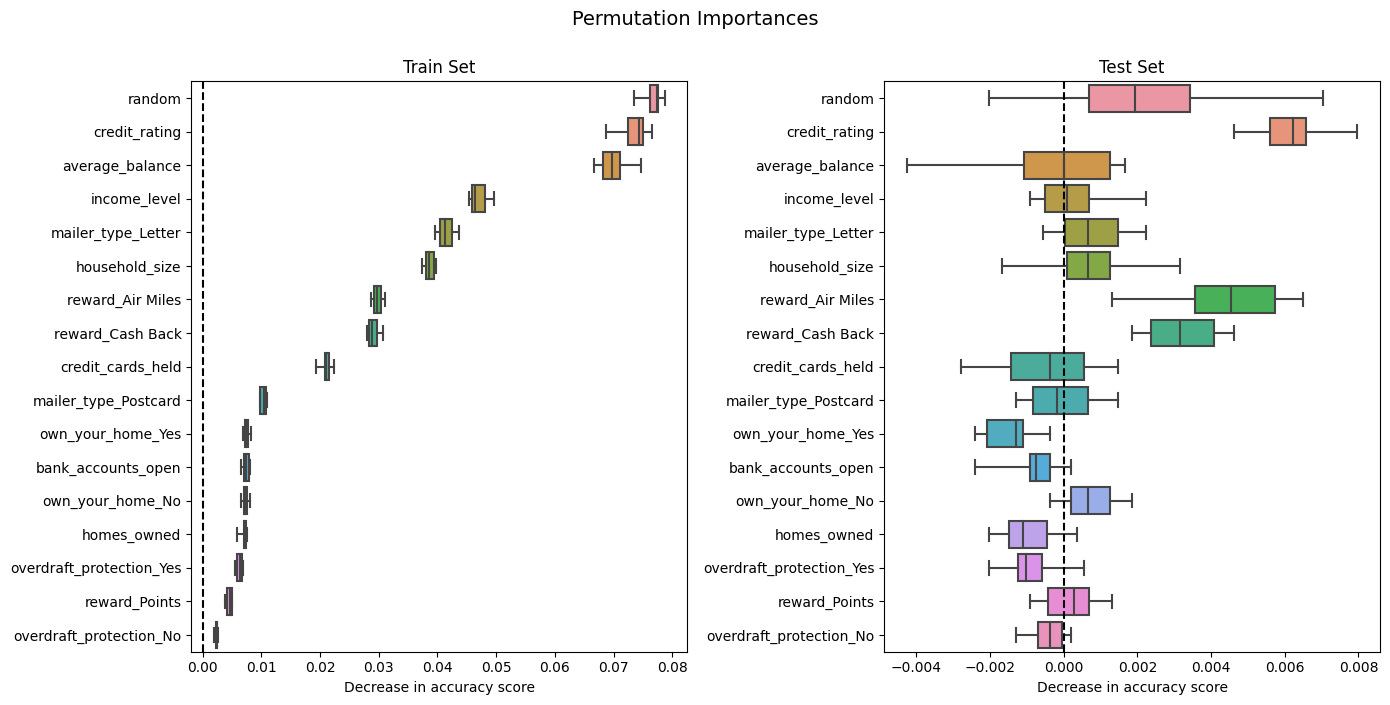

In [618]:
plot_perm_impt(train_impt, test_impt)

> **Note:** For both type of feature importance calculation, the random variable has been deemed the most important!

### SMOTE Data

In [624]:
# SMOTE Data
Xsm_train, Xsm_test, ysm_train, ysm_test = xy_split(X_sm, y_sm)

In [625]:
#Checking the number of records
print(Xsm_train.shape, len(ysm_train))
print(Xsm_test.shape, len(ysm_test))

(23737, 21) 23737
(10173, 21) 10173


In [621]:
# Fitting the model
dt.fit(Xsm_train, ysm_train)

# Model predictions
dtsm_pred = dt.predict(Xsm_test)

In [626]:
dtsm_metrics = metrics_class(ysm_test, dtsm_pred)
dtsm_metrics

Cohen Kappa Score    0.84
Accuracy             0.92
Precision            0.91
Recall               0.93
F1                   0.92
AUC Score            0.92
dtype: float64

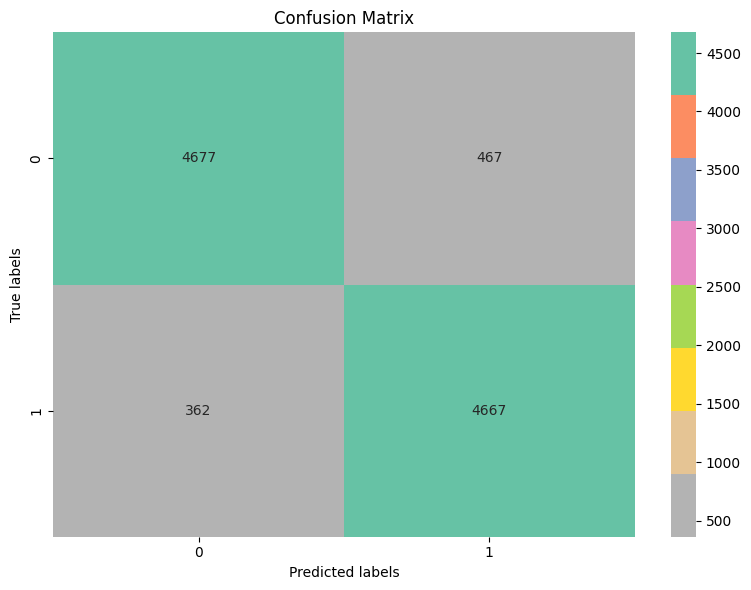

In [627]:
plot_cm(ysm_test, dtsm_pred)

#### SMOTE Data, X Variation: No Quarterly Balance

In [622]:
Xsmavg_train, Xsmavg_test, ysmavg_train, ysmavg_test = xy_split(Xsm_avgbal, y_sm)

In [623]:
logsm_avg_pred, importance_logsm_avg = classify_log(Xsm_avgbal, y_sm)
importance_logsm_avg

NameError: name 'classify_log' is not defined

In [ ]:
logsm_avg_metrics = metrics_class(ysmavg_test, logsm_avg_pred)
logsm_avg_metrics

In [ ]:
plot_cm(ysmavg_test, logsm_avg_pred)

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, log_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(yavg_test, log_pred_avg, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(ysm_test, logsm_pred, pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(ysmavg_test, logsm_avg_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Original Data')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Original with AVG Balance')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='SMOTE Data')
plt.plot(fpr4, tpr4, linestyle='--',color='black', label='SMOTE with AVG Balance')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC Curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_original',dpi=300)
plt.show();